In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns	

from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,auc,average_precision_score,roc_curve,precision_recall_curve, precision_recall_fscore_support

from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

from sklearn.mixture import GaussianMixture


import warnings
warnings.filterwarnings("ignore")

### Hyperparameters

In [2]:
optimizer="lbfgs"
epoch=[100,1000,5000][1]
sample_ratio=[0.05,0.1,0.15,0.3][-1]


print(f"\u001b[33mOptimizer: \u001b[0m{optimizer}\n\u001b[33mEpochs: \u001b[0m{epoch}")
print(f"\u001b[33mSample Ratio: \u001b[0m{sample_ratio*100}%")

Optimizer: lbfgs
Epochs: 1000
Sample Ratio: 30.0%


## Part A: Baseline Model and Data Analysis
### 1) Load the Dataset
We import the credit card transactions dataset using **pandas**.

### Initialize Model Score Dictionary
We create a dictionary `model_scores` to store the evaluation metrics of different models:
- Logistic Regression  
- Gaussian Matrix Model  
- GMM + CBU  

### Standardize Features
We use **StandardScaler** to normalize the `Time` and `Amount` columns so that they have mean 0 and variance 1.  
This step ensures that models are not biased by differences in scale.

### Explore the Data
We call `data.describe()` to view the summary statistics of the dataset after preprocessing.


In [4]:
data=pd.read_csv("creditcard.csv")

# for storing evaluation matrix of each model
model_scores={"Logistic Regression":dict(),"Gaussian Matrix Model":dict(),"GMM + CBU":dict()}


# standardize
st=StandardScaler()
data[["Time","Amount"]]=st.fit_transform(data[["Time","Amount"]])

# data
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,-3.065637e-16,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,2.913952e-17,0.001727
std,1.000002e+00,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,1.000002e+00,0.041527
min,-1.996583e+00,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,-3.532294e-01,0.000000
25%,-8.552120e-01,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,-3.308401e-01,0.000000
50%,-2.131453e-01,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,-2.652715e-01,0.000000
75%,9.372174e-01,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,-4.471707e-02,0.000000
max,1.642058e+00,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.023622e+02,1.000000


In [5]:
y=data["Class"]         # 0->valid, 1->fraud
x=data.drop(["Class"],axis=1)

y.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

### Visualizing Class Distribution

We create a pie chart to show the distribution of **Valid** and **Fraud** transactions in the dataset.

- **Figure Size**: The chart is set to a size of `(3.5, 5)`.  
- **Labels**: Each slice is labeled with the class name (`Valid`, `Fraud`) along with the actual count of samples.  
- **Autopct**: Displays the percentage values up to three decimal places.  
- **Explode**: The `Fraud` slice is slightly separated from the pie chart to highlight it.  
- **Colors**:  
  - Cyan → Valid transactions  
  - Red → Fraud transactions  
- **Title**: The chart is titled *"Class Distribution"*.  
- **Legend**: A legend is added at the top-right outside the plot with class labels.


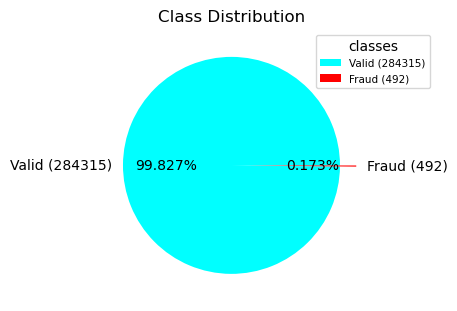

In [6]:
plt.figure(figsize=(3.5, 5))
plt.pie(y.value_counts().values,labels=[f"Valid ({y.value_counts()[0]})",f"Fraud ({y.value_counts()[1]})"],autopct='%2.3f%%',explode=[0,0.15],colors=["cyan","red"])

plt.title("Class Distribution")
plt.legend(title="classes",loc=1,bbox_to_anchor=(1.25,1),fontsize=7.5)

### Train-Test Split

We divide the dataset into **training** and **testing** sets:

- **70% Training Data** (`x_train`, `y_train`)  
- **30% Testing Data** (`x_test`, `y_test`)  

The parameter `random_state=8` ensures reproducibility by generating the same split every time.  

Finally, we print the shapes of the training and testing sets to confirm the split.


In [7]:
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.7,random_state=8)

print(f"x train: {x_train.shape}, y train: {y_train.shape}\nx test: {x_test.shape}, y test: {y_test.shape}")

x train: (199364, 30), y train: (199364,)
x test: (85443, 30), y test: (85443,)


In [8]:
print(y_train.value_counts())   
print(y_test.value_counts())

Class
0    199030
1       334
Name: count, dtype: int64
Class
0    85285
1      158
Name: count, dtype: int64


### 2-3) Logistic Regression Model Training and Evaluation

1. **Model Initialization**  
   - We create a `LogisticRegression` model with:
     - `solver=optimizer` → Optimization algorithm to be used  
     - `max_iter=epoch` → Maximum number of iterations for convergence  
     - `class_weight="balanced"` → Handles class imbalance by assigning weights inversely proportional to class frequencies  

2. **Training**  
   - The model is trained on the **imbalanced training dataset** using `model1.fit(x_train, y_train)`.

3. **Prediction**  
   - Predictions are made on the test set: `y_pred = model1.predict(x_test)`.

4. **Evaluation Metrics**  
   - **Accuracy**: Printed using both `model1.score` and `accuracy_score`.  
   - **Confusion Matrix**: Shows true vs. predicted values.  
   - **Classification Report**: Provides precision, recall, f1-score, and support for each class (`Valid` and `Fraud`).  
   - Results for each class are stored in the `model_scores` dictionary under `"Logistic Regression"`.

5. **Visualization**  
   - A **heatmap of the confusion matrix** is plotted using seaborn (`sns.heatmap`) with labels `Valid` and `Fraud`.  
   - The plot title is *"Confusion Matrix for Logistic Regression"*.


 Logistic Regression Accuracy: 0.977095841672226
 Accuracy on orignal vs predicted values: 0.977095841672226
 Confusion Matrix:
 [[83344  1941]
 [   16   142]]
 report: 
Valid: {'precision': 0.9998080614203455, 'recall': 0.9772410154188896, 'f1-score': 0.9883957425360965, 'support': 85285.0}
Fraud: {'precision': 0.06817090734517522, 'recall': 0.8987341772151899, 'f1-score': 0.12672913877733155, 'support': 158.0}
accuracy: 0.977095841672226
macro avg: {'precision': 0.5339894843827604, 'recall': 0.9379875963170398, 'f1-score': 0.557562440656714, 'support': 85443.0}
weighted avg: {'precision': 0.9980852910313859, 'recall': 0.977095841672226, 'f1-score': 0.9868023607096873, 'support': 85443.0}
----------------------------------------------------------------------------------------------------------------------------------


Text(0.5, 1.0, 'Confusion Matrix for Logistic Regression')

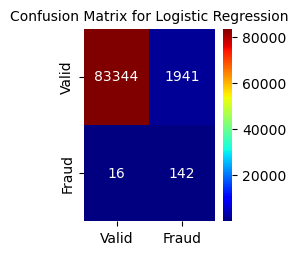

In [10]:
model1=LogisticRegression(solver=optimizer,max_iter=epoch,class_weight="balanced")

# train on imbalance data
model1.fit(x_train,y_train)

# predection on x_test
y_pred=model1.predict(x_test)

# model1 evaluation score
print(f"\u001b[33m Logistic Regression Accuracy: \u001b[0m{model1.score(x_test,y_test)}")
print(f"\u001b[33m Accuracy on orignal vs predicted values: \u001b[0m{accuracy_score(y_test,y_pred)}")
print(f"\u001b[33m Confusion Matrix:\n \u001b[0m{confusion_matrix(y_test,y_pred)}")
print("\u001b[33m report: \u001b[0m")
for k,v in classification_report(y_test,y_pred,output_dict=True,target_names=["\u001b[32mValid\u001b[0m", "\u001b[32mFraud\u001b[0m"]).items():
    print(f"{k}: {v}")

    if k in["\u001b[32mValid\u001b[0m","\u001b[32mFraud\u001b[0m"]:
        model_scores["Logistic Regression"][k[5:-4]]=v
print(f"{'-':-^130}")

plt.figure(figsize=(8,2.5))
plt.subplots_adjust(wspace=0.4)

plt.subplot(1,1,1)
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt="d",cmap="jet",label=["Valid","Fraud"],xticklabels=["Valid", "Fraud"], yticklabels=["Valid", "Fraud"])
plt.title("Confusion Matrix for Logistic Regression",fontdict={"fontsize":10})


## Part B: Gaussian Mixture Models (GMM) – Based Synthetic Sampling
### 1) Difference Between GMM-Based Synthetic Sampling and SMOTE

**1. SMOTE (Synthetic Minority Oversampling Technique)**
- Generates synthetic minority samples by **linear interpolation** between existing minority points and their nearest neighbors.
- Simple and effective for some datasets, but has limitations:
  - Can generate unrealistic samples in **sparse regions**.
  - Does not consider the **underlying probability distribution** of the minority class.
  - May fail when the minority class has **multiple clusters** or complex shapes.

**2. GMM-Based Synthetic Sampling**
- Uses a **Gaussian Mixture Model (GMM)** to learn the **probabilistic distribution** of the minority class.
- Generates synthetic samples by **sampling from the fitted GMM**.
- Advantages:
  - Captures **multi-modal distributions**, representing multiple clusters naturally.
  - Produces synthetic samples that reflect the **underlying structure** of the minority class.
  - Better handles complex shapes and distributions in the feature space, leading to more realistic and informative samples for training.

**Key Takeaway**
> GMM-based sampling is theoretically superior when the minority class is **heterogeneous or has complex sub-groups**, because it models the true distribution instead of just interpolating between points, reducing the risk of creating unrealistic or biased synthetic samples.



### Selecting Optimal Number of Components for GMM

1. **Separate Data by Class**  
   - `x_major`: Majority class samples (Valid), with `Class` column dropped.  
   - `x_minor`: Minority class samples (Fraud), with `Class` column dropped.  

2. **Model Evaluation using Information Criteria**  
   - We train Gaussian Mixture Models (GMM) on the **minority class** for different numbers of components (`k = 1 to 14`).  
   - For each `k`, we calculate:  
     - **AIC (Akaike Information Criterion)**  
     - **BIC (Bayesian Information Criterion)**  
   - Lower values of AIC/BIC indicate a better fit, while also penalizing model complexity.  

3. **Plot AIC/BIC Curve**  
   - Both AIC and BIC scores are plotted against the number of clusters.  
   - The “elbow point” in the curve suggests the optimal number of mixture components for GMM.  

4. **Interpretation**  
   - AIC tends to favor more complex models, while BIC penalizes complexity more strongly.  
   - Choosing the optimal `k` balances **model accuracy** and **simplicity**.


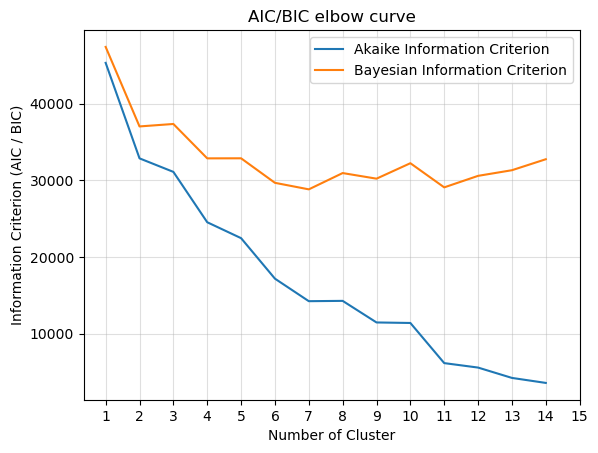

In [11]:
x_major=data[data["Class"]==0].drop(["Class"],axis=1)
x_minor=data[data["Class"]==1].drop(["Class"],axis=1)

aic_score,bic_score=[],[]

for k in range(1,15):
    gmm=GaussianMixture(n_components=k,random_state=8).fit(x_minor)
    aic_score.append(gmm.aic(x_minor))
    bic_score.append(gmm.bic(x_minor))

# print(aic_score) 
# print(bic_score)

plt.plot(aic_score,label="Akaike Information Criterion")
plt.plot(bic_score,label="Bayesian Information Criterion")
plt.xlabel("Number of Cluster")
plt.xticks([i for i in range(15)],[i+1 for i in range(15)])
plt.ylabel("Information Criterion (AIC / BIC)")
plt.title("AIC/BIC elbow curve")

plt.legend()
plt.grid(True,alpha=0.4)

### 2) Preparing Data for GMM-Based Sampling

1. **Set Optimal Number of Components**  
   - From the AIC/BIC analysis, the optimal number of Gaussian components is chosen as `N = 4`.

2. **Minority Class Data (Fraud)**  
   - `x_minor`: Features of minority class with `Class` column dropped.  
   - `y_minor`: Labels of minority class (`Class` column only).  
   - Shapes are printed to verify the split.  

3. **Majority Class Data (Valid)**  
   - `x_major`: Features of majority class with `Class` column dropped.  
   - `y_major`: Labels of majority class (`Class` column only).  
   - Shapes are printed to verify the split.


In [12]:
# based on above the optimal n_componets=4
N=4

x_minor=data[data["Class"]==1].drop(["Class"],axis=1)
y_minor=data[data["Class"]==1]["Class"]
print(f"x minor shape: {x_minor.shape}\ty minor shape: {y_minor.shape}")

x_major=data[data["Class"]==0].drop(["Class"],axis=1)
y_major=data[data["Class"]==0]["Class"]
print(f"x major shape: {y_major.shape}\ty major shape: {y_major.shape}")



x minor shape: (492, 30)	y minor shape: (492,)
x major shape: (284315,)	y major shape: (284315,)


### 3) GMM-Based Synthetic Sampling

1. **Fit GMM on Minority Data**  
   - A Gaussian Mixture Model is trained with `N = 4` components and `covariance_type='full'`.  
   - This models the distribution of the minority (fraud) class.

2. **Generate Synthetic Samples**  
   - Using `gmm.sample()`, we create new synthetic minority samples.  
   - The number of synthetic samples is proportional to the dataset size:  
     \[
     n\_samples = \text{total data size} \times \text{sample ratio}
     \]

3. **Create Balanced Dataset**  
   - **Features (`x_balanced`)**: Concatenate majority class, minority class, and synthetic samples.  
   - **Labels (`y_balanced`)**:  
     - `0` → Majority class  
     - `1` → Minority + Synthetic samples  

4. **Check Shapes and Distribution**  
   - Print the shape of generated synthetic samples.  
   - Print the shape of the final balanced dataset.  
   - Use `np.bincount` to confirm class distribution after balancing.


In [13]:
gmm=GaussianMixture(n_components=N,covariance_type='full', random_state=8)
gmm.fit(x_minor)

x_synthetic,y_synthetic=gmm.sample(n_samples=int(data.shape[0]*sample_ratio))

x_balanced=np.vstack([x_major,x_minor,x_synthetic])
y_balanced=np.hstack([np.zeros(len(x_major)),np.ones(len(x_minor)+len(x_synthetic))])

print(x_synthetic.shape)

x_balanced=np.vstack([x_major,x_minor,x_synthetic])
y_balanced=np.hstack([y_major,y_minor,np.ones(y_synthetic.shape[0])])

print(x_balanced.shape)
print(np.bincount(y_balanced.astype(np.int64)))

(85442, 30)
(370249, 30)
[284315  85934]


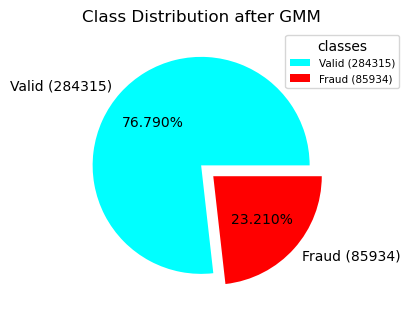

In [14]:
plt.figure(figsize=(3.5, 5))
plt.pie(np.bincount(y_balanced.astype(np.int64)),labels=[f"Valid ({np.bincount(y_balanced.astype(np.int64))[0]})",f"Fraud ({np.bincount(y_balanced.astype(np.int64))[1]})"],autopct='%2.3f%%',explode=[0,0.15],colors=["cyan","red"])

plt.title("Class Distribution after GMM")
plt.legend(title="classes",loc=1,bbox_to_anchor=(1.25,1),fontsize=7.5)

### Logistic Regression on GMM-Balanced Data

1. **Model Initialization**  
   - A new Logistic Regression model (`model2`) is created with the same settings:  
     - `solver=optimizer`  
     - `max_iter=epoch`  
     - `class_weight="balanced"` (kept for stability even though data is balanced).  

2. **Training**  
   - The model is trained on the **GMM-balanced dataset**:  
     \[
     (x\_balanced, y\_balanced)
     \]

3. **Prediction**  
   - Predictions are made on the original test set:  
     \[
     y\_pred = model2.predict(x\_test)
     \]

4. **Evaluation Metrics**  
   - **Accuracy**: Computed using both `score` and `accuracy_score`.  
   - **Confusion Matrix**: Shows the distribution of correct/incorrect predictions.  
   - **Classification Report**: Includes precision, recall, f1-score, and support for `Valid` and `Fraud`.  
   - Results are stored in `model_scores["Gaussian Matrix Model"]`.

5. **Visualization**  
   - A **heatmap of the confusion matrix** is plotted with seaborn.  
   - The chart title is *"Confusion Matrix for Logistic Regression"* (trained on GMM-balanced data).  


 Logistic Regression Accuracy: 0.9831583628851983
 Accuracy on orignal vs predicted values: 0.9831583628851983
 Confusion Matrix:
 [[83859  1426]
 [   13   145]]
 report: 
Valid: {'precision': 0.9998450019076688, 'recall': 0.9832795919563816, 'f1-score': 0.9914931099511105, 'support': 85285.0}
Fraud: {'precision': 0.09229789942711648, 'recall': 0.9177215189873418, 'f1-score': 0.16772700983227298, 'support': 158.0}
accuracy: 0.9831583628851983
macro avg: {'precision': 0.5460714506673926, 'recall': 0.9505005554718617, 'f1-score': 0.5796100598916918, 'support': 85443.0}
weighted avg: {'precision': 0.9981667785050269, 'recall': 0.9831583628851983, 'f1-score': 0.9899698132056922, 'support': 85443.0}
----------------------------------------------------------------------------------------------------------------------------------


Text(0.5, 1.0, 'Confusion Matrix for Logistic Regression')

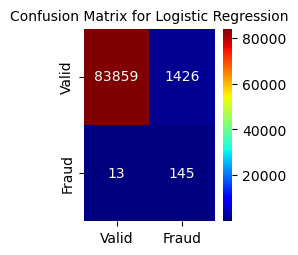

In [16]:
model2=LogisticRegression(solver=optimizer,max_iter=epoch,class_weight="balanced")

# train on balance data
model2.fit(x_balanced,y_balanced)

# predection on x_test
y_pred=model2.predict(x_test)

# model1 evaluation score
print(f"\u001b[33m Logistic Regression Accuracy: \u001b[0m{model2.score(x_test,y_test)}")
print(f"\u001b[33m Accuracy on orignal vs predicted values: \u001b[0m{accuracy_score(y_test,y_pred)}")
print(f"\u001b[33m Confusion Matrix:\n \u001b[0m{confusion_matrix(y_test,y_pred)}")
print("\u001b[33m report: \u001b[0m")
for k,v in classification_report(y_test,y_pred,output_dict=True,target_names=["\u001b[32mValid\u001b[0m", "\u001b[32mFraud\u001b[0m"]).items():
    print(f"{k}: {v}")

    if k in["\u001b[32mValid\u001b[0m","\u001b[32mFraud\u001b[0m"]:
        model_scores["Gaussian Matrix Model"][k[5:-4]]=v
print(f"{'-':-^130}")

plt.figure(figsize=(8,2.5))
plt.subplots_adjust(wspace=0.4)

plt.subplot(1,3,1)
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt="d",cmap="jet",label=["Valid","Fraud"],xticklabels=["Valid", "Fraud"], yticklabels=["Valid", "Fraud"])
plt.title("Confusion Matrix for Logistic Regression",fontdict={"fontsize":10})


## 3) GMM + CBU

### Motivation
- Using **only GMM-based oversampling** can create **too many synthetic samples**.  
- This increases training time and may introduce **noise or overfitting**.  

### Approach
1. **GMM Oversampling (Minority Class)**  
   - Apply a Gaussian Mixture Model (GMM) to the minority class.  
   - Generate synthetic fraud samples to strengthen its representation.  

2. **CBU Undersampling (Majority Class)**  
   - Apply Clustering-Based Undersampling (CBU) on the majority class.  
   - Removes redundant normal samples while maintaining cluster diversity.  
   - Ensures the class ratio remains balanced.  

### Outcome
- The combination of **GMM + CBU** produces a dataset that is:  
  - **Balanced** → Minority class is reinforced, majority class is reduced.  
  - **Compact** → Fewer redundant samples, reduced computational cost.  
  - **Representative** → Maintains diversity of both classes.  
- Improves classifier performance by enhancing **generalization** and reducing training overhead.


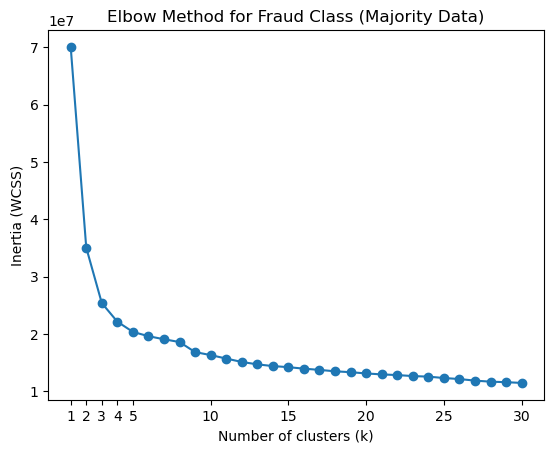

In [17]:
# check value of K for K-CLusters
inertia=[]

for k in range(1,x_balanced.shape[1]+1):
    kmeans=KMeans(n_clusters=k,random_state=8)
    kmeans.fit(x_balanced)
    inertia.append(kmeans.inertia_)

# print(inertia)

plt.plot(inertia,marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for Fraud Class (Majority Data)")
_=plt.xticks([0,1,2,3,4,9,14,19,24,29],labels=[1,2,3,4,5,10,15,20,25,30])

### Clustering Majority Class with K-Means

1. **Set Number of Clusters**  
   - From the previous elbow/silhouette analysis, the optimal number of clusters is chosen as `K = 3`.

2. **Apply K-Means**  
   - Fit a `KMeans` model with `n_clusters=3` on the majority class (`x_major`).  
   - Predict cluster assignments for each sample.

3. **Create Clustered DataFrame**  
   - Convert `x_major` into a DataFrame `xdf_major`.  
   - Add a new column `"cluster"` with the cluster labels assigned by K-Means.  

4. **Check Cluster Distribution**  
   - Use `value_counts()` on the `"cluster"` column to see how many majority samples fall into each cluster.  
   - This distribution helps guide **Clustering-Based Undersampling (CBU)** in later steps.


In [18]:
K=3     # based on above plot

kmeans=KMeans(n_clusters=K,random_state=8)
clusters=kmeans.fit_predict(x_major)

# print(clusters)

# add clustors to dataframe
xdf_major=pd.DataFrame(x_major)
xdf_major["cluster"]=clusters

xdf_major["cluster"].value_counts()

cluster
2    145790
0    132766
1      5759
Name: count, dtype: int64

### Combine Original and Synthetic Minority Data

1. **Merge Features**  
   - `x_minor_new`: Stack the original minority class samples (`x_minor`) with the synthetic samples generated by GMM (`x_synthetic`).  

2. **Merge Labels**  
   - `y_minor_new`: Concatenate the original minority labels (`y_minor`) with labels of synthetic samples (all `1`s).  

3. **Check Shape**  
   - Print the shape of `y_minor_new` to confirm the total number of minority samples after augmentation.  
   - This ensures that both real and synthetic fraud cases are now represented in the minority dataset.


In [19]:
# synetic data from GMM combined with x_minor
x_minor_new=np.vstack([x_minor,x_synthetic])        
y_minor_new=np.hstack([y_minor,np.ones(len(y_synthetic))])

print(y_minor_new.shape)

(85934,)


### Clustering-Based Undersampling (CBU) for Majority Class

1. **Target Size**  
   - The number of samples in the minority class (`x_minor_new.shape[0]`) is chosen as the target size for each cluster of the majority class.  
   - This ensures balanced representation between classes.

2. **Iterate Through Clusters**  
   - For each cluster `c` in the majority class (`xdf_major`):  
     - Extract the samples belonging to that cluster.  
     - If the cluster has **more samples** than the target size → randomly undersample without replacement.  
     - If the cluster has **fewer samples** → keep all of them.  
   - Append results to `x_major_balanced` and `y_major_balanced`.

3. **Concatenate Undersampled Clusters**  
   - Combine all undersampled clusters into `x_major_final` and `y_major_final`.  

4. **Build Final Balanced Dataset**  
   - Merge undersampled majority data with augmented minority data (`x_minor_new`, `y_minor_new`).  
   - Resulting dataset:  
     - `x_balanced`: Feature matrix  
     - `y_balanced`: Labels  

5. **Check Balance**  
   - Print the shapes of `x_balanced` and `y_balanced`.  
   - Use `np.bincount` to confirm the final class distribution after **GMM oversampling + CBU undersampling**.


In [20]:
x_major_balanced=[]
y_major_balanced=[]

target_size=x_minor_new.shape[0]
print(target_size) 

for c in range(K):
    cluster_data=xdf_major[xdf_major["cluster"]==c].drop(["cluster"],axis=1).values
    
    if len(cluster_data)>target_size:
        cluster_balanced=resample(
            cluster_data,
            replace=False,
            n_samples=target_size,
            random_state=8
        )
    else:
        cluster_balanced=cluster_data

    x_major_balanced.append(cluster_balanced)
    y_major_balanced.append(np.zeros(len(cluster_balanced)))

# concat undersampled clusters
x_major_final=np.vstack(x_major_balanced)
y_major_final=np.hstack(y_major_balanced)

x_balanced=np.vstack([x_minor_new,x_major_final])
y_balanced=np.hstack([y_minor_new,y_major_final])


print(x_balanced.shape)
print(y_balanced.shape)
print("After CBO undersampling:", np.bincount(y_balanced.astype(int)))

85934
(263561, 30)
(263561,)
After CBO undersampling: [177627  85934]


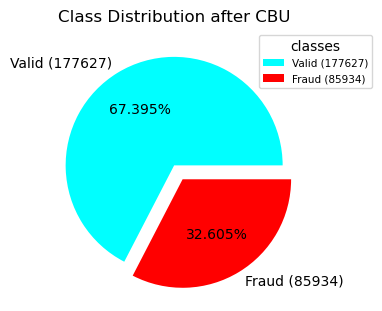

In [21]:
plt.figure(figsize=(3.5, 5))
plt.pie(np.bincount(y_balanced.astype(np.int64)),labels=[f"Valid ({np.bincount(y_balanced.astype(np.int64))[0]})",f"Fraud ({np.bincount(y_balanced.astype(np.int64))[1]})"],autopct='%2.3f%%',explode=[0,0.15],colors=["cyan","red"])

plt.title("Class Distribution after CBU")
plt.legend(title="classes",loc=1,bbox_to_anchor=(1.25,1),fontsize=7.5)

### Logistic Regression on GMM + CBU Balanced Data

1. **Model Initialization**  
   - Create a Logistic Regression model with:  
     - `solver=optimizer` → optimization algorithm  
     - `max_iter=epoch` → maximum iterations  
     - `class_weight="balanced"` → ensures fairness even if slight imbalance exists  

2. **Training**  
   - Fit the model on the **balanced dataset** (`x_balanced`, `y_balanced`) obtained after GMM oversampling and CBU undersampling.  

3. **Prediction**  
   - Predict the labels for the original test set:  
     \[
     y\_pred = model3.predict(x\_test)
     \]

4. **Evaluation Metrics**  
   - **Accuracy**: Overall correct prediction rate  
   - **Confusion Matrix**: Shows True/False Positives and Negatives for `Valid` and `Fraud` classes  
   - **Classification Report**: Precision, Recall, F1-score, and Support per class  
   - Results are stored in `model_scores["GMM + CBU"]` for comparison.  

5. **Visualization**  
   - A **heatmap of the confusion matrix** is plotted using seaborn:  
     - `Valid` and `Fraud` labels on axes  
     - Color-coded matrix to show counts of correct and incorrect predictions  
   - Title: *"Confusion Matrix for Logistic Regression"*


 Logistic Regression Accuracy: 0.9849490303477172
 Accuracy on orignal vs predicted values: 0.9849490303477172
 Confusion Matrix:
 [[84012  1273]
 [   13   145]]
 report: 
Valid: {'precision': 0.9998452841416245, 'recall': 0.9850735768306267, 'f1-score': 0.9924044651822101, 'support': 85285.0}
Fraud: {'precision': 0.10225669957686882, 'recall': 0.9177215189873418, 'f1-score': 0.18401015228426396, 'support': 158.0}
accuracy: 0.9849490303477172
macro avg: {'precision': 0.5510509918592467, 'recall': 0.9513975479089842, 'f1-score': 0.588207308733237, 'support': 85443.0}
weighted avg: {'precision': 0.9981854758909635, 'recall': 0.9849490303477172, 'f1-score': 0.9909095937306241, 'support': 85443.0}
----------------------------------------------------------------------------------------------------------------------------------


Text(0.5, 1.0, 'Confusion Matrix for Logistic Regression')

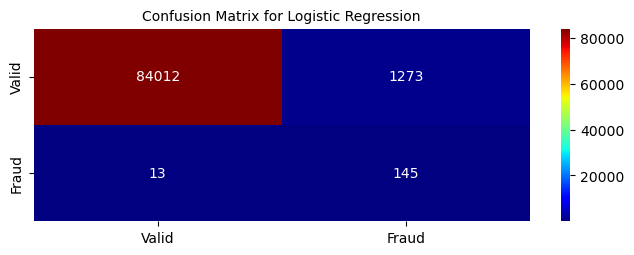

In [25]:
model3=LogisticRegression(solver=optimizer,max_iter=epoch,class_weight="balanced")

# train on balance data
model3.fit(x_balanced,y_balanced)

# predection on x_test
y_pred=model3.predict(x_test)

# model1 evaluation score
print(f"\u001b[33m Logistic Regression Accuracy: \u001b[0m{model3.score(x_test,y_test)}")
print(f"\u001b[33m Accuracy on orignal vs predicted values: \u001b[0m{accuracy_score(y_test,y_pred)}")
print(f"\u001b[33m Confusion Matrix:\n \u001b[0m{confusion_matrix(y_test,y_pred)}")
print("\u001b[33m report: \u001b[0m")
for k,v in classification_report(y_test,y_pred,output_dict=True,target_names=["\u001b[32mValid\u001b[0m", "\u001b[32mFraud\u001b[0m"]).items():
    print(f"{k}: {v}")

    if k in["\u001b[32mValid\u001b[0m","\u001b[32mFraud\u001b[0m"]:
        model_scores["GMM + CBU"][k[5:-4]]=v
print(f"{'-':-^130}")

plt.figure(figsize=(8,2.5))
plt.subplots_adjust(wspace=0.4)

plt.subplot(1,1, 1)
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt="d",cmap="jet",label=["Valid","Fraud"],xticklabels=["Valid", "Fraud"], yticklabels=["Valid", "Fraud"])
plt.title("Confusion Matrix for Logistic Regression",fontdict={"fontsize":10})


## Part C: Performance Evaluation and Conclusion 
### Performance Evaluation

After experimenting with the three models, we observe the following:

- **Precision & F1-Score**: Did not improve significantly.  
  - This could be due to **high bias in the test dataset**.  
  - Since the test set may not represent the true distribution of the data, these metrics can appear distorted.  

- **Recall**: Shows noticeable improvement.  
  - This indicates that the models are **better at identifying the minority class (Fraud)** after applying GMM oversampling and CBU undersampling.  

>Note: Because the test dataset is biased, the precision values may not fully reflect the model's performance in real-world scenarios. Recall is often a more reliable metric for imbalanced datasets.


In [26]:
for name,param in model_scores.items():
    print(name)
    for k,v in param.items():
        print(f"\t{k}:{v}")

Logistic Regression
	Valid:{'precision': 0.9998080614203455, 'recall': 0.9772410154188896, 'f1-score': 0.9883957425360965, 'support': 85285.0}
	Fraud:{'precision': 0.06817090734517522, 'recall': 0.8987341772151899, 'f1-score': 0.12672913877733155, 'support': 158.0}
Gaussian Matrix Model
	Valid:{'precision': 0.9998450019076688, 'recall': 0.9832795919563816, 'f1-score': 0.9914931099511105, 'support': 85285.0}
	Fraud:{'precision': 0.09229789942711648, 'recall': 0.9177215189873418, 'f1-score': 0.16772700983227298, 'support': 158.0}
GMM + CBU
	Valid:{'precision': 0.9998452841416245, 'recall': 0.9850735768306267, 'f1-score': 0.9924044651822101, 'support': 85285.0}
	Fraud:{'precision': 0.10225669957686882, 'recall': 0.9177215189873418, 'f1-score': 0.18401015228426396, 'support': 158.0}


### Performance Comparison Across Models

We compare the performance of the three models—**Logistic Regression (LR)**, **GMM**, and **GMM + CBU**—for both classes (`Valid` and `Fraud`) using **Precision, Recall, and F1-Score**.

#### Steps:

1. **Separate Metrics by Class**
   - Extract metrics from `model_scores` for `Valid` and `Fraud` separately.
   - For each class, collect `precision`, `recall`, and `f1-score`.

2. **Bar Charts**
   - **Left subplot**: Metrics for `Valid` class  
     - X-axis: Models (`LR`, `GMM`, `GMM + CBU`)  
     - Bars: Precision, Recall, F1-Score  
     - Y-axis range: 0.9–1.0 for better visualization  
     - Values are annotated above bars for clarity.
   - **Right subplot**: Metrics for `Fraud` class  
     - X-axis: Models (`LR`, `GMM`, `GMM + CBU`)  
     - Bars: Precision, Recall, F1-Score  
     - Values are annotated above bars for clarity.


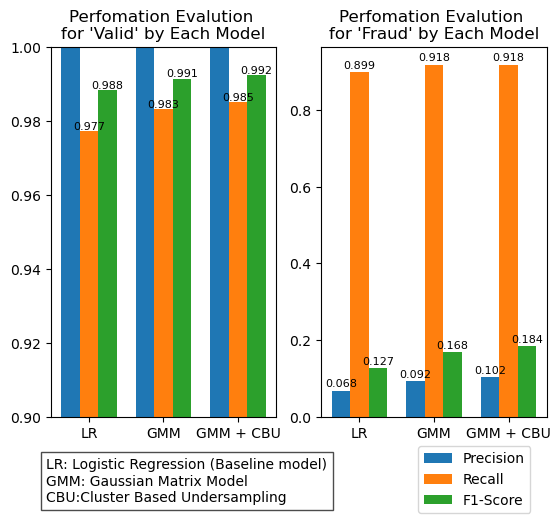

In [27]:
valid=[]
fraud=[]
for name,metric in model_scores.items():
    for k,v in metric.items():
        valid.append(v) if k=="Valid" else fraud.append(v)

vp=[d["precision"] for d in valid]
vr=[d["recall"] for d in valid]
vf1=[d["f1-score"] for d in valid]

fp=[d["precision"] for d in fraud]
fr=[d["recall"] for d in fraud]
ff1=[d["f1-score"] for d in fraud]


fig,ax=plt.subplots(1,2)
ax[0].bar([i-0.25 for i in range(len(model_scores))],vp,0.25,label="Precision")
ax[0].bar([i for i in range(len(model_scores))],vr,0.25,label="Recall")
ax[0].bar([i+0.25 for i in range(len(model_scores))],vf1,0.25,label="F1-Score")

ax[0].set_xticks([0,1,2])
ax[0].set_xticklabels(["LR","GMM","GMM + CBU"],rotation=0)

ax[0].set_ylim(bottom=0.9,top=1.0)
ax[0].set_title("Perfomation Evalution \nfor 'Valid' by Each Model")
ax[0].legend(loc="center left", bbox_to_anchor=(1.6, -0.17))

# # add text on bar
for i,x in enumerate(vr):
    ax[0].text(i,x+0.0005,f"{x:.3f}",ha="center",fontdict={"fontsize":8})
for i,x in enumerate(vf1):
    ax[0].text(i+0.25,x+0.0005,f"{x:.3f}",ha="center",fontdict={"fontsize":8})

# 2nd axis
ax[1].bar([i-0.25 for i in range(len(model_scores))],fp,0.25,label="Precision")
ax[1].bar([i for i in range(len(model_scores))],fr,0.25,label="Recall")
ax[1].bar([i+0.25 for i in range(len(model_scores))],ff1,0.25,label="f1-Score")

# add text on bar
for i,x in enumerate(fp):
    ax[1].text(i-0.25,x+0.01,f"{x:.3f}",ha="center",fontdict={"fontsize":8})
for i,x in enumerate(fr):
    ax[1].text(i,x+0.01,f"{x:.3f}",ha="center",fontdict={"fontsize":8})
for i,x in enumerate(ff1):
    ax[1].text(i+0.25,x+0.01,f"{x:.3f}",ha="center",fontdict={"fontsize":8})

ax[1].set_xticks([0,1,2])
ax[1].set_xticklabels(["LR","GMM","GMM + CBU"],rotation=0)

ax[1].set_title("Perfomation Evalution \nfor 'Fraud' by Each Model")

plt.text(-4.2, -0.22, "LR: Logistic Regression (Baseline model)\nGMM: Gaussian Matrix Model \nCBU:Cluster Based Undersampling", fontsize=10,
         bbox=dict(facecolor="white", alpha=0.7))


if "assests" not in os.listdir("./"):
    os.makedirs("assests")
plt.savefig(f"./assests/model comparision ({optimizer}_{epoch}_{sample_ratio}).png",bbox_inches="tight")

### Impact of GMM-Based Oversampling on Classifier Performance

1. **Improved Detection of Minority Class**
   - After applying **GMM-based oversampling**, the number of synthetic minority samples (Fraud) increased.
   - This allowed the classifier to **learn patterns from the minority class more effectively**, resulting in improved **recall** for Fraud detection.

2. **Effect on Precision and F1-Score**
   - While **recall** improved, **precision** and **F1-score** for the minority class did not improve significantly.
   - This may be due to **bias in the test dataset** or because generating synthetic samples can introduce **some noise**, slightly affecting precision.

3. **Overall Model Performance**
   - The model becomes **better at identifying Fraud cases** (higher true positives).  
   - There might be a small trade-off with false positives (slightly lower precision), but overall, the classifier is more **sensitive to the minority class**, which is critical in fraud detection scenarios.

> ✅ Conclusion: GMM-based oversampling effectively improves the model’s ability to detect the minority class, especially when dealing with highly imbalanced datasets.


## Final Recommendation

Based on the experiments and analysis, the use of **GMM-based synthetic data generation** is **effective** in improving the classifier’s ability to detect the minority class (Fraud) in this highly imbalanced dataset.

### Justification:

1. **Empirical Results**
   - **Recall Improvement**: After GMM oversampling, the model shows a **significant increase in recall** for the minority class, indicating better detection of fraud cases.  
   - **Balanced Dataset**: By generating synthetic samples, the dataset becomes more balanced, allowing the classifier to learn patterns from both classes more effectively.  
   - **Overall Performance**: While precision and F1-score saw minimal changes, the increase in recall is critical in fraud detection where identifying positive cases is more important than missing some negatives.

2. **Theoretical Understanding**
   - GMM models the **probabilistic distribution of the minority class**, capturing multi-modal characteristics and generating **realistic synthetic samples**.  
   - Unlike simple oversampling methods (e.g., SMOTE), GMM reduces the risk of generating unrealistic data in sparse regions and better represents complex distributions.  
   - When combined with methods like CBU, it can maintain **dataset diversity** while controlling dataset size, reducing noise and computational cost.

### ✅ Recommendation:
Use **GMM-based synthetic sampling** (optionally combined with CBU) as a strategy for handling imbalanced datasets in fraud detection. It enhances the classifier’s sensitivity to the minority class without significantly compromising overall model stability.
